### Modeling Time Series Exercises

The end result of this exercise should be a Jupyter notebook named model.

Using saas.csv or log data from API usage or store_item_sales

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [143]:
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [144]:
# create new column: date, then sort by date column, and set it as index. 
# month_invoiced can be dropped.
df = df.assign(ds = pd.to_datetime(df.Month_Invoiced)).sort_values('ds').set_index('ds').drop(columns = ['Customer_Id', 'Invoice_Id', 'Month_Invoiced'])

# remove leap year too
df = df[df.index != '2016-02-29']

In [45]:
# no more leap days included!
df.shape

(774439, 2)

In [44]:
# split dataset into train, validate, and test
# obtain tvt dataframe sizes
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size
print(train_size)
print(validate_size)
print(test_size)
print(train_size + validate_size + test_size)

387219
232331
154889
774439


In [64]:
df.index.value_counts(normalize=True)

2014-01-31    0.025825
2014-02-28    0.025567
2014-03-31    0.025307
2014-04-30    0.025067
2014-05-31    0.024819
2014-06-30    0.024583
2014-07-31    0.024341
2014-08-31    0.024110
2014-09-30    0.023881
2014-10-31    0.023647
2014-11-30    0.023430
2014-12-31    0.023237
2015-01-31    0.023022
2015-02-28    0.022829
2015-03-31    0.022636
2015-04-30    0.022437
2015-05-31    0.022242
2015-06-30    0.022066
2015-07-31    0.021888
2015-08-31    0.021715
2015-09-30    0.021527
2015-10-31    0.021343
2015-11-30    0.021160
2015-12-31    0.021006
2016-01-31    0.020843
2016-03-31    0.020525
2016-04-30    0.020372
2016-05-31    0.020253
2016-06-30    0.020106
2016-07-31    0.019963
2016-08-31    0.019827
2016-09-30    0.019679
2016-10-31    0.019555
2016-11-30    0.019432
2016-12-31    0.019289
2017-01-31    0.019162
2017-02-28    0.019034
2017-03-31    0.018936
2017-04-30    0.018821
2017-05-31    0.018691
2017-06-30    0.018594
2017-07-31    0.018480
2017-08-31    0.018347
2017-09-30 

In [67]:
validate.tail()

,Subscription_Type,Amount
ds,,
2017-02-05,10679.0,53395.0
2017-02-12,0.0,0.0
2017-02-19,0.0,0.0
2017-02-26,0.0,0.0
2017-03-05,1945.0,9725.0


In [145]:
# slice into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

# verify sliced splits
print(len(train) + len(validate) + len(test) == len(df))
print(df.head(1) == train.head(1))

True
            Subscription_Type  Amount
ds                                   
2014-01-31               True    True


In [146]:
# resample datasets
train = train.resample('W').sum()
validate = validate.resample('W').sum()
test = test.resample('W').sum()

In [147]:
def plot_splits(target_var):
    plt.figure(figsize = (12, 4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var])
    plt.title(target_var)
    plt.show()

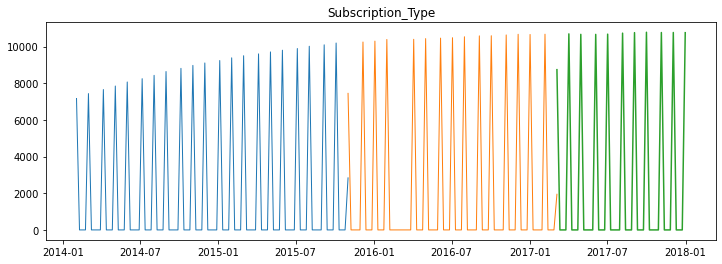

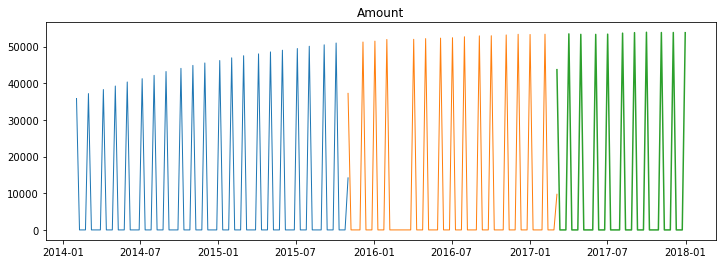

In [148]:
for col in train.columns:
    plot_splits(col)

2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
 - Simple Average
 - Moving Average
 - Holt's Linear Trend Model
 - Based on previous year/month/etc., this is up to you.

In [149]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12, 4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    plt.show()
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))

In [150]:
# create empty dataframe
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison down the line
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

eval_df

,model_type,target_var,rmse


In [151]:
# Simple average
subscription = round(train['Subscription_Type'].mean(), 0)
amount = round(train['Amount'].mean(), 0)

def make_predictions():
    yhat_df = pd.DataFrame({'Subscription_Type': [subscription], 'Amount': [amount]}, index = validate.index)
    
    return yhat_df

yhat_df = make_predictions()
yhat_df.head()

,Subscription_Type,Amount
ds,,
2015-11-01,2073.0,10366.0
2015-11-08,2073.0,10366.0
2015-11-15,2073.0,10366.0
2015-11-22,2073.0,10366.0
2015-11-29,2073.0,10366.0


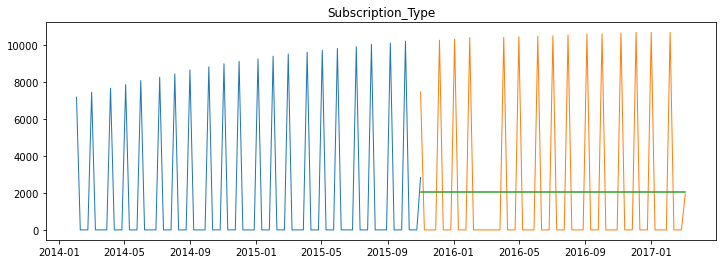

Subscription_Type -- RMSE: 4215


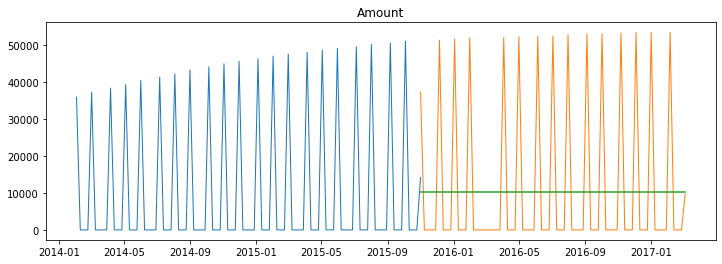

Amount -- RMSE: 21077


In [152]:
for col in train.columns:
    plot_and_eval(col)

In [153]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,Subscription_Type,4215.0
1,simple_average,Amount,21077.0


In [154]:
# moving average, bi-weekly

period = 2

subscription = round(train['Subscription_Type'].rolling(period).mean().iloc[-1], 0)
amount = round(train['Amount'].rolling(period).mean().iloc[-1], 0)

yhat_df = make_predictions()
yhat_df.head()

,Subscription_Type,Amount
ds,,
2015-11-01,1420.0,7098.0
2015-11-08,1420.0,7098.0
2015-11-15,1420.0,7098.0
2015-11-22,1420.0,7098.0
2015-11-29,1420.0,7098.0


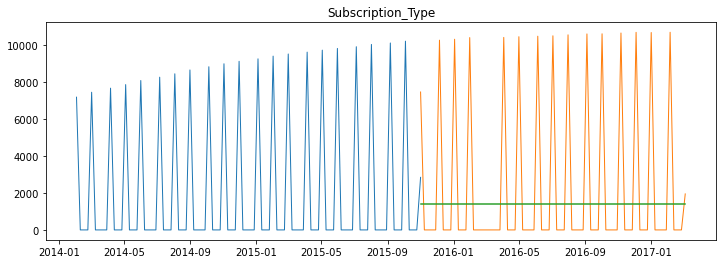

Subscription_Type -- RMSE: 4286


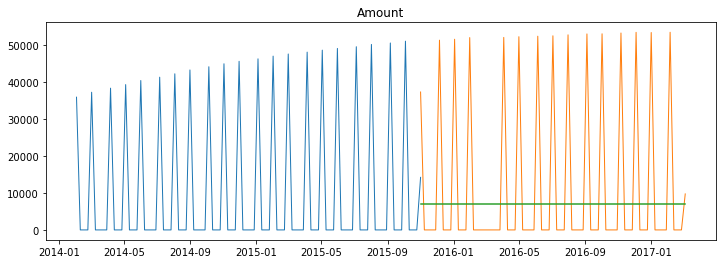

Amount -- RMSE: 21429


In [155]:
for col in train.columns:
    plot_and_eval(col)

In [156]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'bi-weekly_moving_average', target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,Subscription_Type,4215.0
1,simple_average,Amount,21077.0
2,bi-weekly_moving_average,Subscription_Type,4286.0
3,bi-weekly_moving_average,Amount,21429.0


In [157]:
# holt's linear trend

for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1,
                     smoothing_slope = .1,
                     optimized = False)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

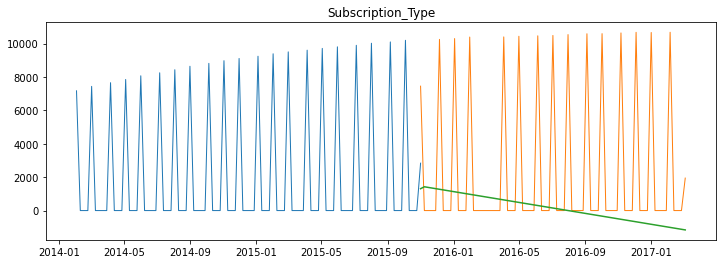

Subscription_Type -- RMSE: 4757


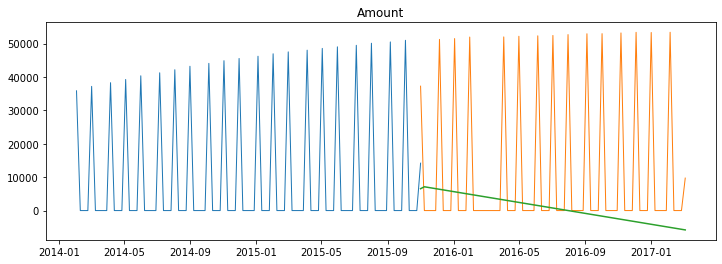

Amount -- RMSE: 23783


In [158]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [159]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)

In [160]:
eval_df

,model_type,target_var,rmse
0,simple_average,Subscription_Type,4215.0
1,simple_average,Amount,21077.0
2,bi-weekly_moving_average,Subscription_Type,4286.0
3,bi-weekly_moving_average,Amount,21429.0
4,Holts,Subscription_Type,4757.0
5,Holts,Amount,23783.0


In [161]:
# previous cycle by year
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [172]:
yhat_df = train + train.diff(1).mean()
pd.concat([yhat_df.head(1), validate.head(1)])

,Subscription_Type,Amount
ds,,
2014-01-31,0.0,0.0
2016-01-31,0.0,0.0


ValueError: Found input variables with inconsistent numbers of samples: [170256, 431894]

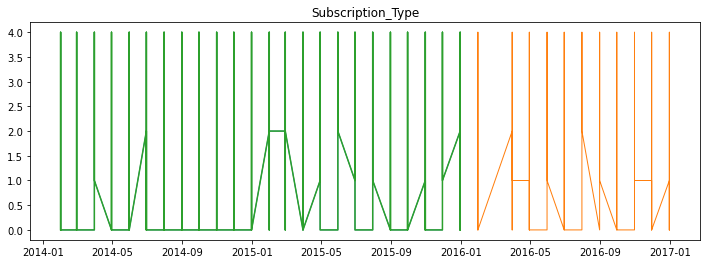

In [173]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)